# Attention Walmart Shoppers
### A Walmart retail analysis

The data was originally retrieved from:
 -   https://www.kaggle.com/rutuspatel/retail-analysis-with-walmart-sales-data
 - https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

### Data Dictionary

| Target       |  Data Type       | Description                     |
|--------------|------------------|---------------------------------|
| Weekly_Sales |   float64        | Sales in USD per week by store  |


| Column        |  Data Type       | Description                                      |  
|---------------|------------------|--------------------------------------------------|
| Store         |     int64        | unique identifier for store  (1-45)              |
| Date          |     object       | Date of transaction                              |
| Holiday_Flag  |     int64        | indicator of a Holiday week (boolean)            |
| Temperature   |     float64      | temperature in Farenheight                       |
| Fuel_Price    |     float64      | cost of fuel(in USD) in region                   |
| CPI           |     float64      | Prevailing consumer price index, cost of goods   |
| Unemployment  |     float64      | Prevailing unemployment rate                     |

## Goal:
- to predict weekly sales price for a store

## Think about...
- What is your goal?
- what is your TARGET? drivers for that target?
- what is one oberservation? what does one row from your dataset represent?

## Daily meetings
- standup doc
- shared knowledge doc

### Three important Questions
- what did you work on since we last talked?
- what are you planning on working on next?
- what are your blockers?

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#custom modules
import wrangle
import new_wrangle

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
#bring in walmart data using new_wrangle.py
df= new_wrangle.acquire_data()

In [3]:
#take a look
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


In [4]:
#check for nulls, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#import the cleaned data using new_wrangle.py
df= new_wrangle.wrangle_walmart()

In [6]:
#make sure that all columns are created
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   int64  
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

In [7]:
#take a look at the data
df.tail()

,store_id,weekly_sales,holiday_flag,temperature,fuel_price,CPI,unemployment,store_type,store_size,month,...,quarter,weekday,week_of_year,deflated_series,sales_delta_weekly,sales_delta_yearly,gas_delta_weekly,gas_delta_yearly,season,holiday_name
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-26,25,688940.94,0,56,3.88,216.152,7.293,B,128107,October,...,4,Friday,43,3187.30,3409.09,-35503.03,-0.09,0.31,Fall,no_holiday
2012-10-26,5,319550.77,0,71,3.51,224.038,5.422,C,34875,October,...,4,Friday,43,1426.32,6192.62,12515.66,-0.08,0.14,Fall,no_holiday
2012-10-26,40,921264.52,0,49,3.92,138.728,4.145,A,155083,October,...,4,Friday,43,6640.80,3094.02,-20411.43,-0.08,0.32,Fall,no_holiday
2012-10-26,18,1127516.25,0,56,3.92,138.728,8.243,B,120653,October,...,4,Friday,43,8127.53,78809.50,20873.62,-0.08,0.32,Fall,no_holiday
2012-10-26,45,760281.43,0,58,3.88,192.309,8.667,B,118221,October,...,4,Friday,43,3953.44,42155.90,-21413.14,-0.09,0.31,Fall,no_holiday


In [8]:
#train test split
X_train, y_train, X_test, y_test = new_wrangle.train_test(df,'weekly_sales')

X_train -> (5445, 20)
X_test -> (990, 20)


In [9]:
y_train.head()

Date
2010-02-05    1643690.90
2010-02-05    2193048.75
2010-02-05     536006.73
2010-02-05     789036.02
2010-02-05     465108.52
Name: weekly_sales, dtype: float64

<hr style="border:2px solid black"> </hr>

# Explore

In [10]:
#count of season
df.season.value_counts()

Summer    2925
Winter    1350
Spring    1215
Fall       945
Name: season, dtype: int64

In [11]:
#counts by holidays
df.holiday_name.value_counts()

no_holiday      5985
super_bowl       135
labor_day        135
thanksgiving      90
christmas         90
Name: holiday_name, dtype: int64

In [12]:
#counts by quarter
df.quarter.value_counts()

3    1800
2    1755
1    1485
4    1395
Name: quarter, dtype: int64

## bivariate exploration

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

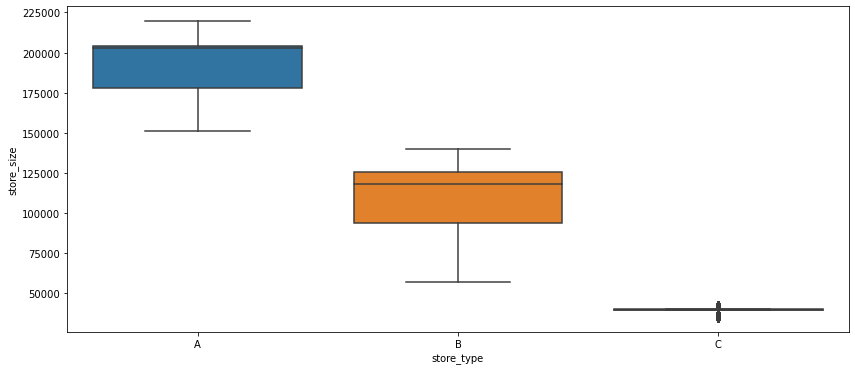

In [13]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=df)

### Takeaways:
- Store A: appears to be only larger stores
- Store B: appear to be midsized stores
- Store C: appears to be only smaller stores

- outliers were addressed (store 3, store 5, store 33, store 36 were classified incorrectly)

<AxesSubplot:xlabel='store_type', ylabel='weekly_sales'>

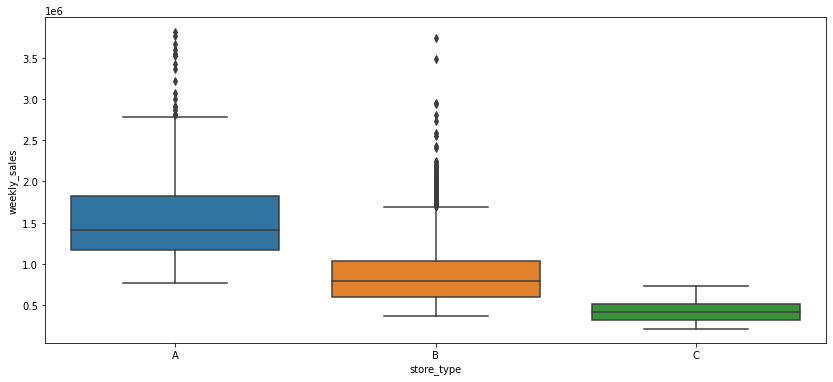

In [14]:
#visualize stores and weekly sales
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='weekly_sales', data=df)

<AxesSubplot:xlabel='store_type', ylabel='unemployment'>

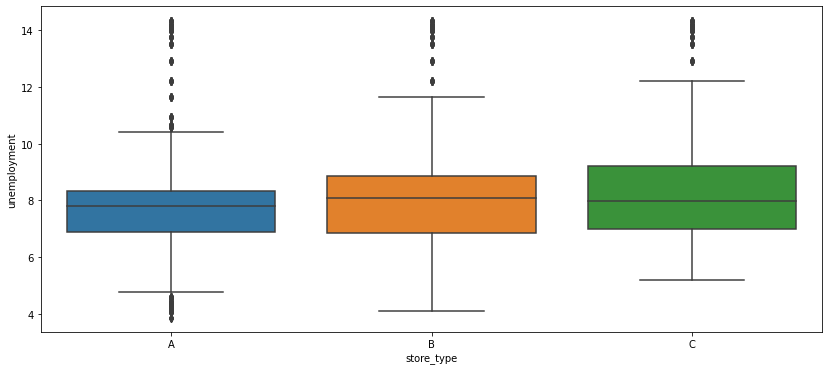

In [15]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='unemployment', data=df)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store_id            6435 non-null   int64  
 1   weekly_sales        6435 non-null   float64
 2   holiday_flag        6435 non-null   int64  
 3   temperature         6435 non-null   int64  
 4   fuel_price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   unemployment        6435 non-null   float64
 7   store_type          6435 non-null   object 
 8   store_size          6435 non-null   int64  
 9   month               6435 non-null   object 
 10  year                6435 non-null   int64  
 11  quarter             6435 non-null   int64  
 12  weekday             6435 non-null   object 
 13  week_of_year        6435 non-null   int64  
 14  deflated_series     6435 non-null   float64
 15  sales_delta_weekly  6435 non-null   f

<AxesSubplot:xlabel='fuel_price', ylabel='temperature'>

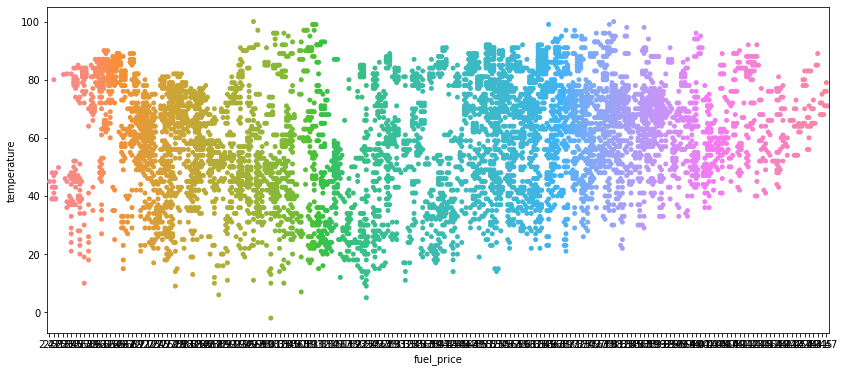

In [40]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='fuel_price', y='temperature', data=df)

<AxesSubplot:xlabel='fuel_price', ylabel='weekly_sales'>

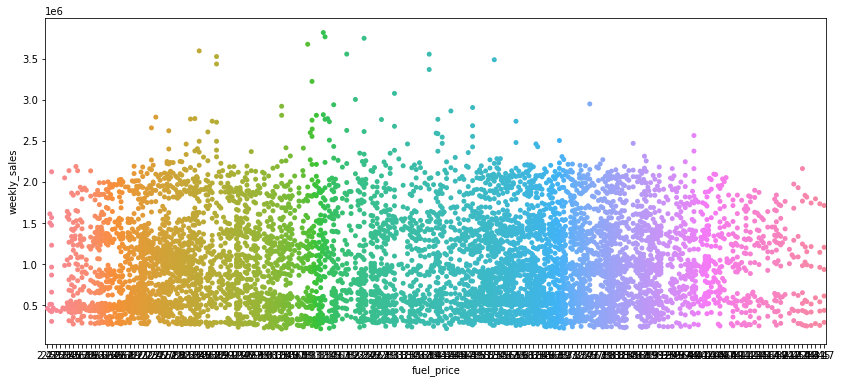

In [41]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='fuel_price', y='weekly_sales', data=df)

<AxesSubplot:xlabel='week_of_year', ylabel='weekly_sales'>

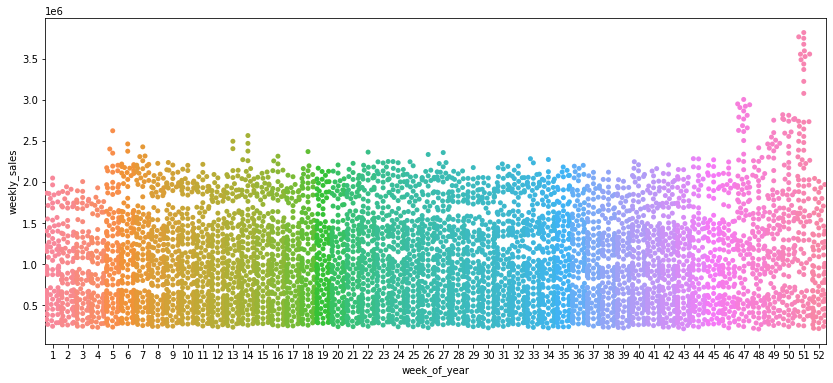

In [42]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='week_of_year', y='weekly_sales', data=df)

<AxesSubplot:xlabel='season', ylabel='weekly_sales'>

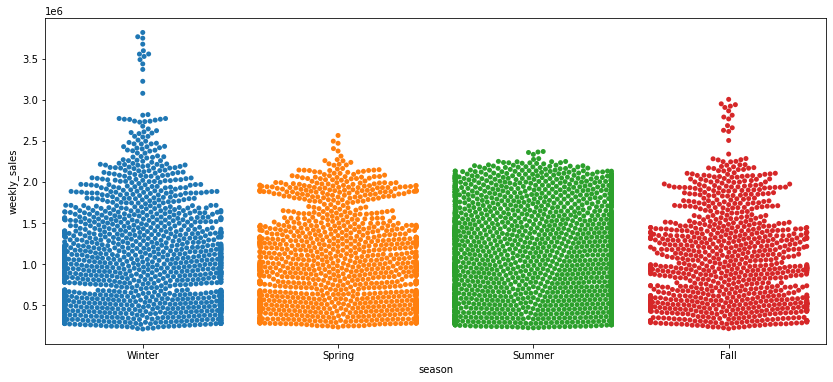

In [44]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='season', y='weekly_sales', data=df)

<AxesSubplot:xlabel='month', ylabel='weekly_sales'>

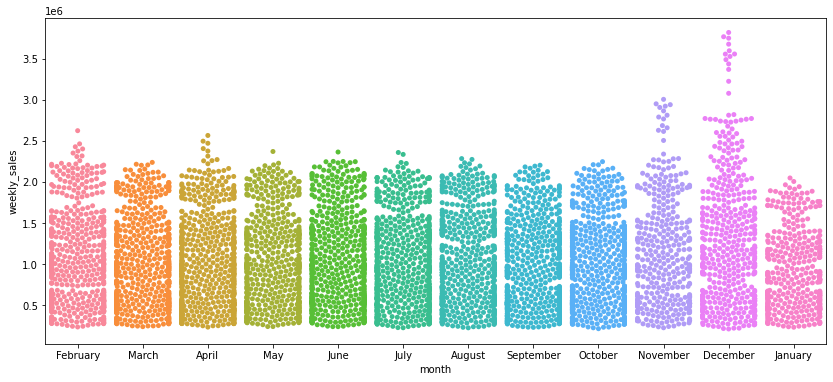

In [45]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.swarmplot(x='month', y='weekly_sales', data=df)